# Working with historic data from Alpaca

In [13]:
import asyncio
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.data.enums import DataFeed
from alpaca.data.timeframe import TimeFrame
import matplotlib.pyplot as plt
from datetime import datetime
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest

# Load environment variables
load_dotenv()  # Load .env file

API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")

# Initialize TradingClient
Trading_Client = TradingClient(API_KEY, API_SECRET, paper=True)  # paper=True for paper trading
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

In [37]:
# --- Strategy Parameters & Costs ---
SYMBOL = "TSLA"
STOP_LOSS_PCT = 0.027
TAKE_PROFIT_PCT = 0.05
COMMISSION_PER_TRADE = 0.50 # Example cost for an entry and exit trade

# --- Initialize Alpaca Data Client ---
data_client = StockHistoricalDataClient(API_KEY, API_SECRET)

# --- Fetch Historical Data ---
# NOTE: Fetching a full year of 1-minute data is memory-intensive.
# For longer backtests, consider fetching data in smaller, daily or weekly chunks.
print(f"Fetching 1-minute historical data for {SYMBOL}...")
request = StockBarsRequest(
    symbol_or_symbols=SYMBOL,
    timeframe=TimeFrame.Minute,
    start=datetime(2024, 1, 1),
    end=datetime(2025, 1, 1)
)
bars = data_client.get_stock_bars(request)
df = bars.df
print("Data fetched successfully.")

# --- Clean & Prepare Data ---
if df.empty:
    raise ValueError("No data returned from Alpaca. Check symbol and date range.")

tesla = df.copy()
# If data for a single symbol is returned, the multi-index is not present
if isinstance(df.index, pd.MultiIndex):
    tesla = df[df.index.get_level_values('symbol') == SYMBOL].copy()
    tesla.index = tesla.index.droplevel('symbol')

tesla.index = tesla.index.tz_convert("America/New_York")
tesla = tesla.rename(columns={
    "open": "Open", "high": "High", "low": "Low",
    "close": "Close", "volume": "Volume"
})
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# --- 20-Day Average Volume Calculation (Corrected to avoid look-ahead bias) ---
print("Calculating 20-day average volume...")
# Calculate total volume for each day
daily_volume = tesla.groupby(tesla.index.date)['Volume'].sum()

# Calculate the 20-day rolling average of PAST daily volumes.
# .shift(1) is crucial to ensure we only use data available *before* the current day.
daily_avg_vol = daily_volume.rolling(window=20).mean().shift(1)

# Map the daily average volume to each minute of the corresponding day
tesla['Day'] = tesla.index.date
tesla['20D_Avg_Volume'] = tesla['Day'].map(daily_avg_vol)
tesla = tesla.drop(columns=['Day']) # Clean up the helper column
tesla = tesla.ffill() # Forward-fill to handle the initial NaN period

# --- Backtesting Loop ---
print("Running backtest...")
grouped = tesla.groupby(tesla.index.date)
trades = []

for date, group in grouped:
    group = group.sort_index()
    # Ensure there's enough data and the average volume is calculated
    if len(group) < 20 or group['20D_Avg_Volume'].isna().all():
        continue

    opening_range = group.between_time("09:30", "10:00")
    after_opening = group.between_time("10:01", "16:00")

    if opening_range.empty or after_opening.empty:
        continue

    high_or = opening_range['High'].max()
    low_or = opening_range['Low'].min()
    or_range = high_or - low_or
    or_pct = or_range / low_or if low_or > 0 else 0

    threshold = 0.02 if or_pct < 0.01 else 0.01
    long_break_price = high_or * (1 + threshold)
    short_break_price = low_or * (1 - threshold)

    long_trade_done = short_trade_done = False

    for i in range(len(after_opening)):
        row = after_opening.iloc[i]
        idx = after_opening.index[i]

        avg_daily_volume = row['20D_Avg_Volume']
        if pd.isna(avg_daily_volume):
            continue

        # Volume threshold for 1-minute bar (390 minutes in a trading day)
        vol_threshold = 1.5 * avg_daily_volume / 390

        # --- LONG TRADE ---
        if not long_trade_done and row['High'] >= long_break_price and row['Volume'] > vol_threshold:
            entry_price = row['Close']
            stop_loss = entry_price * (1 - STOP_LOSS_PCT)
            max_price = entry_price
            tesla.at[idx, 'Position'] = 'Long'

            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                max_price = max(max_price, forward['High'])
                trailing_stop = max_price * (1 - TAKE_PROFIT_PCT)
                
                if forward['Low'] <= stop_loss or forward['Low'] <= trailing_stop:
                    exit_price = min(stop_loss, trailing_stop) if forward['Low'] <= trailing_stop else stop_loss
                    pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE
                    break
            else: # If loop finishes without a break (exit at market close)
                exit_price = after_opening.iloc[-1]['Close']
                pnl = (exit_price - entry_price) - COMMISSION_PER_TRADE

            tesla.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Long'})
            long_trade_done = True

        # --- SHORT TRADE ---
        elif not short_trade_done and row['Low'] <= short_break_price and row['Volume'] > vol_threshold:
            entry_price = row['Close']
            stop_loss = entry_price * (1 + STOP_LOSS_PCT)
            min_price = entry_price
            tesla.at[idx, 'Position'] = 'Short'

            for j in range(i + 1, len(after_opening)):
                forward = after_opening.iloc[j]
                min_price = min(min_price, forward['Low'])
                trailing_stop = min_price * (1 + TAKE_PROFIT_PCT)
                
                if forward['High'] >= stop_loss or forward['High'] >= trailing_stop:
                    exit_price = max(stop_loss, trailing_stop) if forward['High'] >= trailing_stop else stop_loss
                    pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE
                    break
            else: # Exit at market close
                exit_price = after_opening.iloc[-1]['Close']
                pnl = (entry_price - exit_price) - COMMISSION_PER_TRADE

            tesla.at[idx, 'PnL'] = pnl
            trades.append({'Date': idx.date(), 'Entry': entry_price, 'Exit': exit_price, 'PnL': pnl, 'Position': 'Short'})
            short_trade_done = True

        if long_trade_done and short_trade_done:
            break

print("Backtest finished.")

Fetching 1-minute historical data for TSLA...
Data fetched successfully.
Calculating 20-day average volume...
Running backtest...
Backtest finished.



--- Trade Summary ---
Total Trades: 138
Winning %: 43.48%
Total PnL: $-85.02
Average PnL: $-0.62


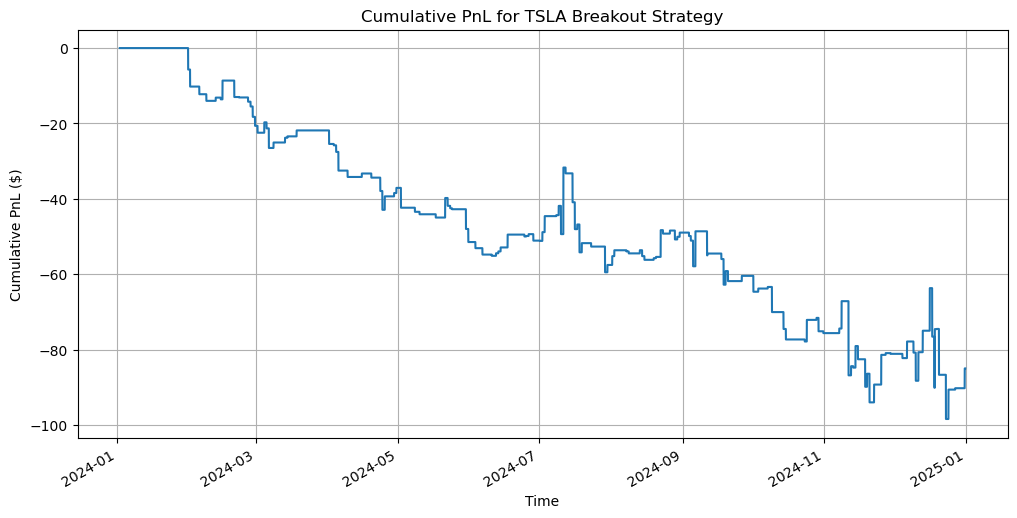

In [38]:
# --- Metrics and Visualization ---
print("\n--- Trade Summary ---")
trades_df = pd.DataFrame(trades)
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()

if not trades_df.empty:
    print(f"Total Trades: {len(trades_df)}")
    winning_trades = (trades_df['PnL'] > 0).sum()
    win_rate = (winning_trades / len(trades_df)) * 100 if len(trades_df) > 0 else 0
    print(f"Winning %: {win_rate:.2f}%")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Average PnL: ${trades_df['PnL'].mean():.2f}")
      # --- Plot ---
    plt.figure(figsize=(12, 6))
    tesla['Cumulative_PnL'].plot(title=f'Cumulative PnL for {SYMBOL} Breakout Strategy')
    plt.xlabel("Time")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.show()
else:
    print("No trades were executed during the backtest period.")